### **Importing Libraries**

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

#NLP Libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

#Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ME781/reviews.csv")

### **Checking for Null Values**

In [ ]:
print(f"Total Number of Null Values in the data are: {df.isnull().sum().sum()}")

Total Number of Null Values in the data are: 0


### **Exploratory Data Analysis**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
print(f"Number of Datapoints in the Dataset: {len(df)}")
print(f"Unique Ratings in the Rating Section: {df['Rating'].nunique()}")

Number of Datapoints in the Dataset: 20491
Unique Ratings in the Rating Section: 5


Text(0, 0.5, 'Number of Reviews')

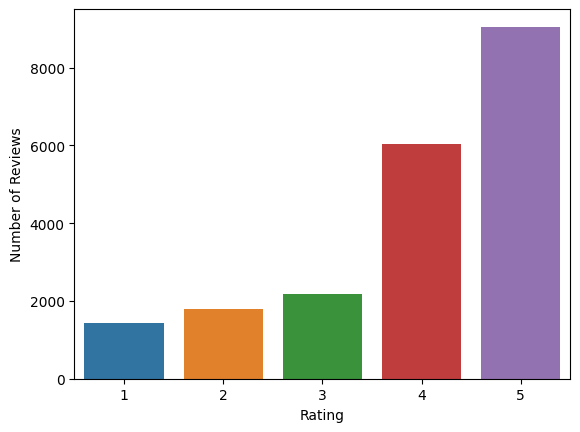

In [ ]:
#Checking number of observations for each target variable
sns.countplot(x="Rating",data = df)
plt.ylabel("Number of Reviews")

In [ ]:
def map_to_category(value):
    if value in [4, 5, 3]:
        return 1
    elif value in [1, 2]:
        return 0
    else:
        return 'Unknown'

#Map function to apply the mapping function to each element in the Series
df["Rating"] = df["Rating"].map(map_to_category)

Text(0, 0.5, 'Number of Reviews')

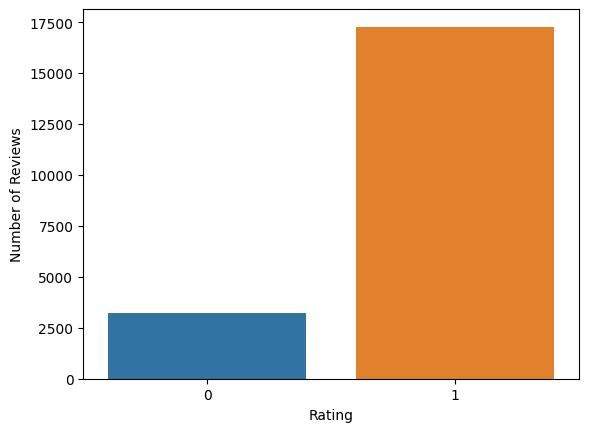

In [ ]:
#Checking number of observations for each target variable
sns.countplot(x="Rating",data = df)
plt.ylabel("Number of Reviews")

### **Pre-processing the Text Data**

#### **Lowercasing Characters and Stopword Removal**

In [ ]:
result = set(stopwords.words('english'))
df["Review"] = df["Review"].str.lower()
def remove_stopword(text):
  filter = str(text).split()
  return " ".join([word for word in filter if word not in result])
df['Review'] = df['Review'].apply(lambda text: remove_stopword(text))

#### **Removing Punctuations**

In [ ]:
p = string.punctuation
def remove_punctuations(text):
  t = str.maketrans("","",p)
  return text.translate(t)
df['Review'] = df['Review'].apply(lambda text: remove_punctuations(text))

#### **Tokenization, Stemming and Lemmatization of Words**

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['Review'] = df['Review'].apply(tokenizer.tokenize)
st = nltk.PorterStemmer()
def stem_words(data):
  text = [st.stem(word) for word in data]
  return data
df['Review'] = df['Review'].apply(lambda x: stem_words(x))
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df['Review'] = df['Review'].apply(lambda x: lemmatizer_on_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### **Word Cloud for Visualization**

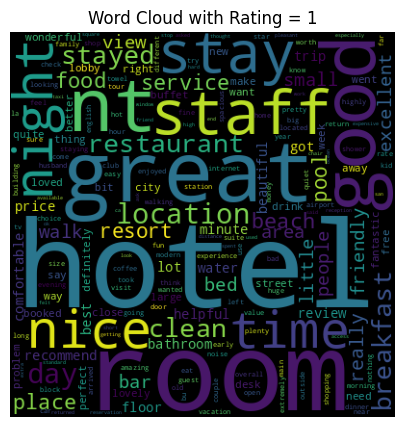

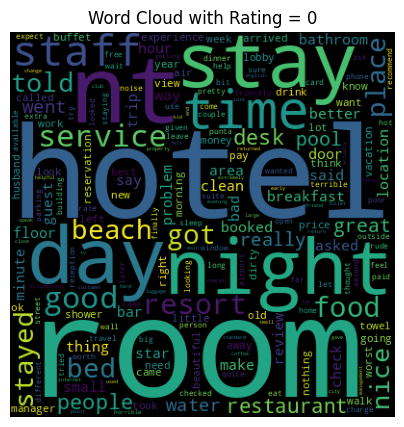

In [ ]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=400, height=400,collocations=False).generate(text)

    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Sample text data for word clouds
text1 = " ".join(str(x).replace("'","") for x in df[df['Rating'] == 1]["Review"])
text2 = " ".join(str(x).replace("'","") for x in df[df['Rating'] == 0]["Review"])

# Generate and display word clouds side by side
generate_wordcloud(text1, "Word Cloud with Rating = 1")
generate_wordcloud(text2, "Word Cloud with Rating = 0")

### **Sentiment Analysis Model**

In [ ]:
#Splitting into Test and Train
X = df["Review"]
y = df["Rating"]
X = X.apply(lambda x: ' '.join(x))
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05,random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

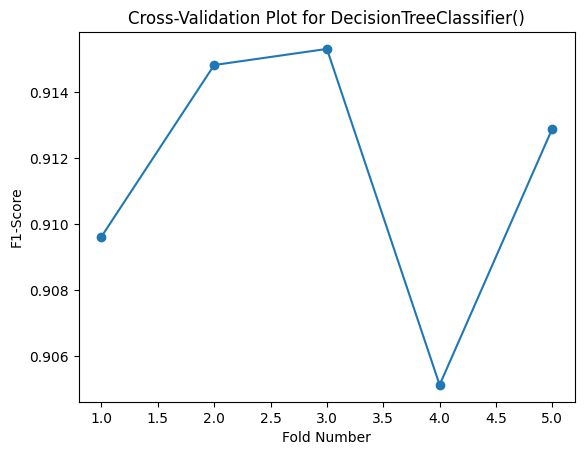

Mean Cross-Validation F1 Score: 0.9115552440947052 for DecisionTreeClassifier()


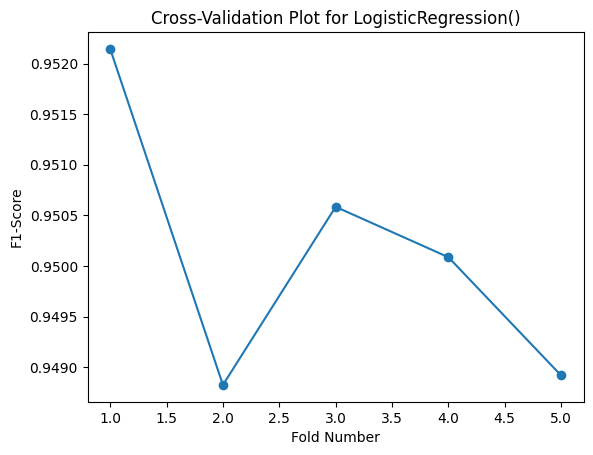

Mean Cross-Validation F1 Score: 0.9501125501798201 for LogisticRegression()


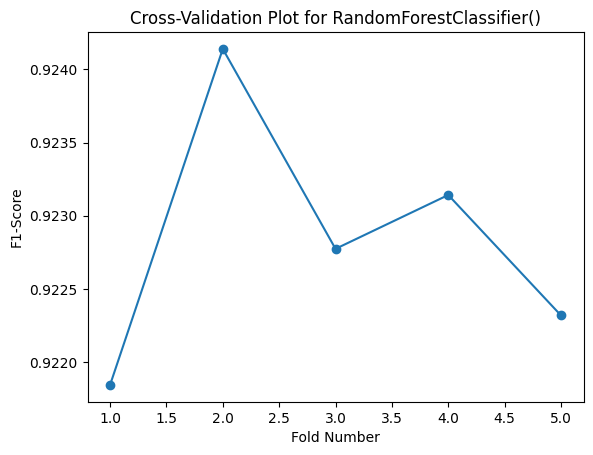

Mean Cross-Validation F1 Score: 0.9228438267997433 for RandomForestClassifier()


In [ ]:
n_splits = 5

models = [DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier()]

for model in models:
  # Initialize arrays for storing accuracies
  accuracies = np.zeros(n_splits)

  # Stratified Cross-Validation
  kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
      X_train1, X_test1 = X_train[train_index], X_train[test_index]
      y_train1, y_test1 = y_train[train_index], y_train[test_index]

      #Vectorization
      vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
      vectoriser.fit(X_train1)
      X_train1 = vectoriser.transform(X_train1)
      X_test1  = vectoriser.transform(X_test1)
      # Train the model
      model.fit(X_train1, y_train1)

      # Make predictions
      y_pred = model.predict(X_test1)

      # Calculate accuracy
      accuracies[i] = f1_score(y_test1, y_pred)
  x = [i for i in range(1,len(accuracies)+1)]
  plt.plot(x,accuracies,marker='o')
  plt.xlabel('Fold Number')
  plt.ylabel('F1-Score')
  plt.title(f'Cross-Validation Plot for {model}')
  # Show the plot
  plt.show()
  # Print the mean accuracy across folds
  print(f"Mean Cross-Validation F1 Score: {np.mean(accuracies)} for {model}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
logistic_regression = LogisticRegression()
param_dist = {
    'penalty': ['l2', 'none'],
    'C': np.logspace(-4, 4, 20),
    'max_iter': [100, 250, 500, 1000]
}
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# RandomizedSearchCV
random_search = RandomizedSearchCV(logistic_regression,
                                   param_distributions=param_dist, n_iter=10,
                                   n_jobs=-1, cv=5, verbose=2, random_state=42,
                                   scoring='f1')
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
f1_score = random_search.best_estimator_.score(X_test, y_test)
print("Test Accuracy:", f1_score)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best Parameters: {'penalty': 'none', 'max_iter': 100, 'C': 29.763514416313132}
Test Accuracy: 0.9414634146341463


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
model = LogisticRegression()
model.set_params(**random_search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.74      0.78       147
           1       0.96      0.97      0.97       878

    accuracy                           0.94      1025
   macro avg       0.89      0.86      0.88      1025
weighted avg       0.94      0.94      0.94      1025



In [ ]:
print(confusion_matrix(y_test, y_pred))

[[109  38]
 [ 22 856]]


In [ ]:
import joblib

joblib.dump(model, 'logistic_regression_model.pkl')

# Save the TFIDF vectorizer
joblib.dump(vectoriser, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

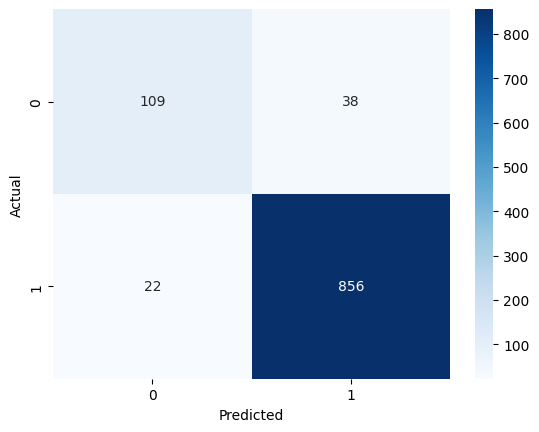

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()